In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy
from scipy import ndimage, misc
from PIL import Image
import time
from scipy.ndimage import median_filter, gaussian_filter
from matplotlib import cm
from tqdm import tqdm

In [3]:
def kspace_alloo(image_shape: tuple, pixel_size: float = 1):
    # Multiply by 2pi for correct values, since DFT has 2pi in exponent
    rows = image_shape[0]
    columns = image_shape[1]
    m = np.fft.fftshift(np.fft.fftfreq(rows, d=pixel_size)) # spatial frequencies relating to "rows" in real space
    n = np.fft.fftshift(np.fft.fftfreq(columns, d=pixel_size)) # spatial frequencies relating to "columns" in real space
    ky = (2*np.pi*m) # defined by row direction
    kx = (2*np.pi*n) # defined by column direction
    return kx, ky
def lowpass_2D(image, r, pixel_size):
    # -------------------------------------------------------------------
    # This function will generate a low-pass filter and suppress the input spatial frequencies,
    #kr of the image, beyond some defined
    # spatial frequency r
    # DEFINITIONS
    # image: input image whos spatial frequencies you want to suppress
    # r: spatial frequency you want to suppress beyond [pixel number]
    # pixel_size: physical size of pixel [microns]
    # -------------------------------------------------------------------
    rows = image.shape[0]
    columns = image.shape[1]
    m = np.fft.fftshift(np.fft.fftfreq(rows, d=pixel_size))  # spatial frequencies relating to "rows" in real space
    n = np.fft.fftshift(np.fft.fftfreq(columns, d=pixel_size))  # spatial frequencies relating to "columns" in real space
    ky = (2 * np.pi * m)  # defined by row direction
    kx = (2 * np.pi * n)  # defined by column direction

    kx2 = kx ** 2
    ky2 = ky ** 2
    kr2 = np.add.outer(ky2, kx2)
    kr = np.sqrt(kr2)

    lowpass_2d = np.exp(-r * (kr ** 2))

    # plt.imshow(lowpass_2d)
    # plt.title('Low-Pass Filter 2D')
    # plt.colorbar()
    # plt.show()

    return lowpass_2d
def highpass_2D(image, r, pixel_size):
    # -------------------------------------------------------------------
    # This function will generate a high-pass filter and suppress the input spatial frequencies,
    # kr of the image, up to some defined
    # spatial frequency r
    # DEFINITIONS
    # image: input image whos spatial frequencies you want to suppress
    # r: spatial frequency you want to suppress beyond [pixel number]
    # pixel_size: physical size of pixel [microns]
    # -------------------------------------------------------------------
    rows = image.shape[0]
    columns = image.shape[1]
    m = np.fft.fftshift(np.fft.fftfreq(rows, d=pixel_size))  # spatial frequencies relating to "rows" in real space
    n = np.fft.fftshift(np.fft.fftfreq(columns, d=pixel_size))  # spatial frequencies relating to "columns" in real space
    ky = (2 * np.pi * m)  # defined by row direction
    kx = (2 * np.pi * n)  # defined by column direction

    kx2 = kx ** 2
    ky2 = ky ** 2
    kr2 = np.add.outer(ky2, kx2)
    kr = np.sqrt(kr2)

    highpass_2d = 1 - np.exp(-r * (kr ** 2))

    # plt.imshow(highpass_2d)
    # plt.title('High-Pass Filter 2D')
    # plt.colorbar()
    # plt.show()

    return highpass_2d
def midpass_2D(image, r, pixel_size):
    # -------------------------------------------------------------------
    # This function will generate a low-pass filter and suppress the input spatial frequencies,
    # kr of the image, up to some defined
    # spatial frequency r
    # DEFINITIONS
    # image: input image whos spatial frequencies you want to suppress
    # r: spatial frequency you want to suppress beyond [pixel number]
    # pixel_size: physical size of pixel [microns]
    # -------------------------------------------------------------------
    rows = image.shape[0]
    columns = image.shape[1]
    m = np.fft.fftshift(np.fft.fftfreq(rows, d=pixel_size))  # spatial frequencies relating to "rows" in real space
    n = np.fft.fftshift(np.fft.fftfreq(columns, d=pixel_size))  # spatial frequencies relating to "columns" in real space
    ky = (2 * np.pi * m)  # defined by row direction
    kx = (2 * np.pi * n)  # defined by column direction

    kx2 = kx ** 2
    ky2 = ky ** 2
    kr2 = np.add.outer(ky2, kx2)
    kr = np.sqrt(kr2)

    highpass_2d = 1 - np.exp(-r * (kr ** 2))

    C = np.zeros(columns, dtype=np.complex128)
    C = C + 0 + 1j
    kx, ky = kspace_alloo(image.shape, pixel_size)  # taking x as columns and y as rows
    ikx = kx * C  # (i) * spatial frequencies in x direction (along columns) - as complex numbers ( has "0" in the real components, and "kx" in the complex)
    denom = np.add.outer((-1 * ky), ikx)  # array with ikx - ky (DENOMINATOR)

    midpass_2d = np.divide(complex(1., 0.) * highpass_2d, denom, out=np.zeros_like(complex(1., 0.) * highpass_2d),
                           where=denom != 0)  # Setting output equal to zero where denominator equals zero

    # plt.imshow(np.real(midpass_2d))
    # plt.title('Mid-Pass Filter 2D')
    # plt.colorbar()
    # plt.show()

    return midpass_2d

In [4]:
num_masks = 6
Energy =19*1000
beta_PMMA = 2.5298E-10
delta_PMMA = 5.8317E-07 
gamma = delta_PMMA/beta_PMMA # Ratio of real to imaginary components of the sample's refractive index
wavelength = 1.2398/Energy # [microns]
prop = 0.35*10**6 # [microns]
pixel_size = 55 # [microns]
energy = 26.75 # [keV]
print(gamma)

2305.2019922523523


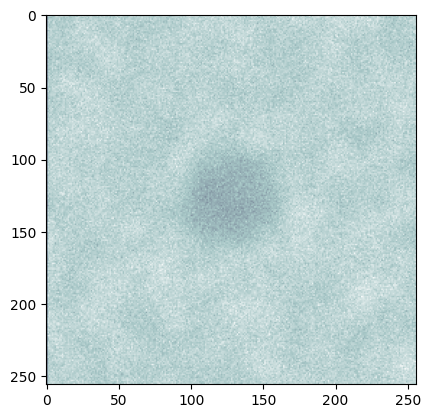

In [5]:
xleft = 0 # Establishing the desired cropping: For the Wattle Flower data this crops out the image headers, which is required
xright = 256
ytop = 0
ybot = 256
rows = 256 # Total number of rows in image (after cropping)
columns = 256 # Total number of columns in image (after cropping)
Ir = np.empty([int(num_masks),int(rows),int(columns)]) # Establishing empty arrays to put SB-PCXI data into
Is = np.empty([int(num_masks),int(rows),int(columns)])
I_ref,Isamp= [],[]
for i in range(7):
    I_ref.append(np.loadtxt("FS_Measurements_txt_Files/REF_SiC_60um_FS300um_21kev_2x150_75_AIR_0{}.txt".format(i)))#Nylon_TxT_Files/RAW_SiC_F85D15_3x_Poli_00.txt
    Isamp.append(np.loadtxt("FS_Measurements_txt_Files/RAW_SiC_60um_FS300um_21kev_2x150_75_AIR_0{}.txt".format(i)))
#Ir = np.load(f"DATA_Prosesada_26.75keV/REF_FF_26.75keV.npy") # Establishing empty arrays to put SB-PCXI data into
#Is = np.load(f"DATA_Prosesada_26.75keV/RAW_FF_26.75keV.npy")
plt.imshow(Isamp[0],cmap='bone')  
Ir= np.array(I_ref)
Is= np.array(Isamp)

In [6]:
coeff_D = []  # Empty lists to store terms required to solve the system of linear equations
coeff_dx = []
coeff_dy = []
lapacaian = []
RHS = []

coefficient_A = np.empty([int((num_masks)), 4, int(rows), int(columns)]) # Empty arrays to put calculated terms in and to perform QR decomposition on
coefficient_b = np.empty([int((num_masks)), 1, int(rows), int(columns)])


for i in tqdm(range(num_masks)): # This forloop will calculate and store all of the requires coefficients for the system of linear equations
    rhs = (1 / prop) * (Ir[i, :, :] - Is[i, :, :])
    lap = Ir[i, :, :]
    deff = (-1) * np.divide(ndimage.laplace(Ir[i, :, :]), pixel_size ** 2)
    dy, dx = np.gradient(Ir[i, :, :], pixel_size)
    dy_r = -2 * dy
    dx_r = -2 * dx

    coeff_D.append(deff)
    coeff_dx.append(dx_r)
    coeff_dy.append(dy_r)
    lapacaian.append(lap)
    RHS.append(rhs)

100%|██████████| 6/6 [00:00<00:00, 766.62it/s]


In [7]:
for n in tqdm(range(len(coeff_dx))):
    coefficient_A[n, :, :, :] = np.array([lapacaian[n], coeff_D[n], coeff_dx[n], coeff_dy[n]])
    coefficient_b[n, :, :, :] = RHS[n]

100%|██████████| 6/6 [00:00<00:00, 1947.82it/s]


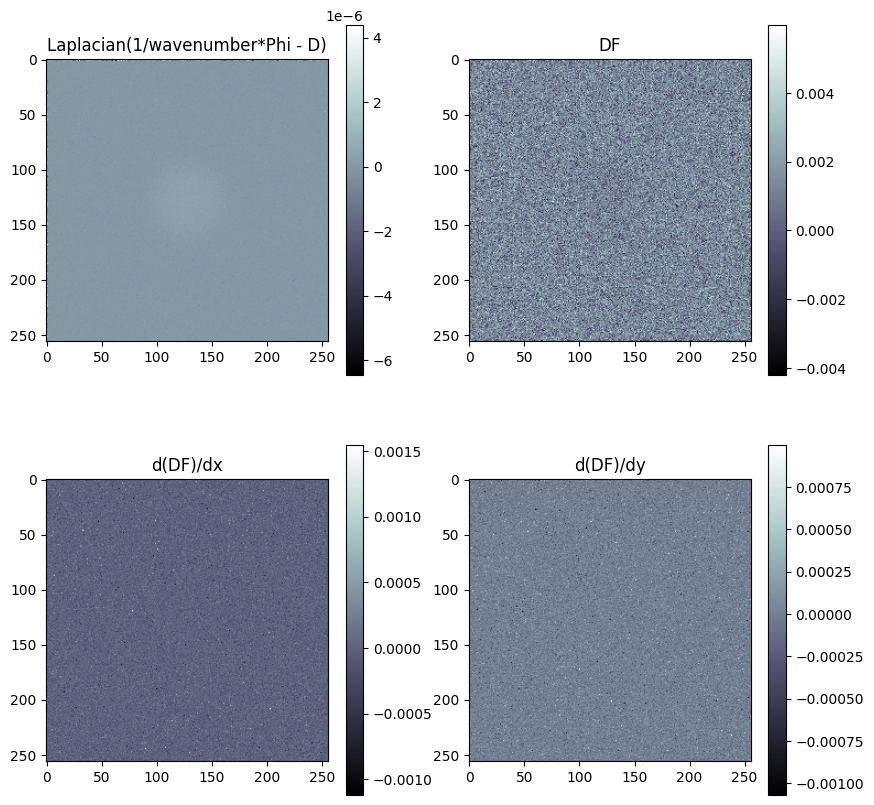

In [8]:
identity = np.identity(4)  # This is applying the Tikhonov Regularisation to the QR decomposition
alpha = np.std(coefficient_A) / 10000 # This is the optimal Tikhonov regularisation parameter (may need tweaking if the system is overly unstable)
reg = np.multiply(alpha, identity)  # 4x4 matrix representing the Tikhinov regularization on the coefficient array
reg_repeat = np.repeat(reg, rows * columns).reshape(4, 4, rows, columns) # Repeating the regularisation across all pixel positions
zero_repeat = np.zeros((4, 1, rows, columns))  # 4x1 matrix representing the Tikhinov regularization on the righthand-side vector
coefficient_A_reg = np.vstack([coefficient_A, reg_repeat])  # Coefficient matrix of linear system that is Tikhonov regularised
coefficient_b_reg = np.vstack([coefficient_b, zero_repeat])  # RHS of linear system that is Tikhonov regularised

vector_qr = np.vectorize(np.linalg.qr, signature='(m,n)->(m,p),(p,n)') # Making the Numpy QR decomposition function operate on vectors

reg_A_mv = np.moveaxis(coefficient_A_reg, [0, 1, 2, 3], [2, 3, 0, 1]) # Moving axis to ensure the QR is performed on the correct axis
reg_Qr, reg_Rr = vector_qr(reg_A_mv)  # Doing QR decomposition such that A = QR
reg_Qr_mv = np.moveaxis(reg_Qr, [2, 3, 1, 0], [0, 1, 2, 3])  # Move axis back to where it Was
reg_QT_mv = np.matrix.transpose(reg_Qr_mv)  # Taking the transpose of Q
reg_Rin = np.linalg.inv(reg_Rr)  # Taking the inverse of R
reg_xleft = np.matmul(reg_Rin, reg_QT_mv)  # Calculating R^-1Q^T
reg_b_mv = np.moveaxis(coefficient_b_reg, [0, 1, 2, 3], [2, 3, 0, 1]) # Moving axis to ensure the matrix multiplication is performed correctly
reg_x = np.matmul(reg_xleft, reg_b_mv)  # Calculating the unknown vector, x = [Laplacian(1/wavenumber*Phi - D), D, D_dx, D_dy]

lap_phiDF = reg_x[:, :, 0, 0] # Laplacian term array (Laplacian(1/wavenumber*Phi - D))
DFqr = reg_x[:, :, 1, 0]  # DF array (DF_reg)
dxDF = reg_x[:, :, 2, 0]  # d(DF)/dx array
dyDF = reg_x[:, :, 3, 0]  # d(DF)/dy array
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(lap_phiDF,cmap='bone')
plt.title('Laplacian(1/wavenumber*Phi - D)')
plt.colorbar()
plt.subplot(2,2,2)
plt.imshow(DFqr,cmap='bone')
plt.title('DF')
plt.colorbar()
plt.subplot(2,2,3)
plt.imshow(dxDF,cmap='bone')
plt.title('d(DF)/dx')
plt.colorbar()
plt.subplot(2,2,4)
plt.imshow(dyDF,cmap='bone')
plt.title('d(DF)/dy')
plt.colorbar()
plt.show()
#np.savetxt(f'MIST_ALUMINA_RESULTS/Lap1wave_{energy}kev.txt', lap_phiDF)


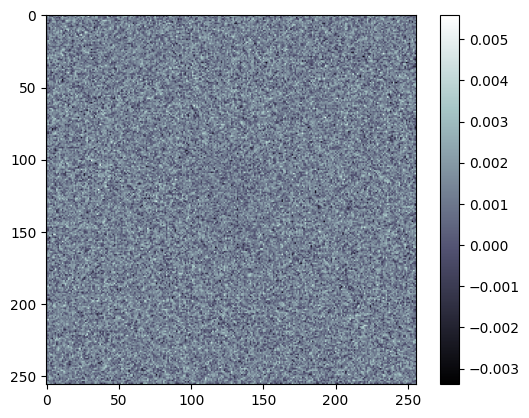

In [9]:
cutoff = 100 #10 by default # This can be determined by optimising the SNR and NIQE for a given cut-off parameter value
                #rangeOcut = range(0,200,5) # This for-loop can be used to generate 100 filtered dark-field signals for different cut-off parameter values, just place the next 21 lines of code into the for-loop.
                #for cutoff in rangeOcut:

i_dyDF = dyDF * (np.zeros((DFqr.shape),
                          dtype=np.complex128) + 0 + 1j)  # (i) * derivative along rows of DF, has "0" in the real components, and "d(DF)/dx" in the complex

insideft = dxDF + i_dyDF
insideftm = np.concatenate((insideft, np.flipud(insideft)), axis=0) # Mirroring the term inside the Fourier transform to enforce periodic boundary conditions
ft_dx_idy = np.fft.fftshift(np.fft.fft2(insideftm))
MP = midpass_2D(ft_dx_idy, cutoff, pixel_size)
MP_deriv = MP * ft_dx_idy # This is the 'derivative solution' mid-pass filtered

DFqrm = np.concatenate((DFqr, np.flipud(DFqr)), axis=0)
ft_DFqr = np.fft.fftshift(np.fft.fft2(DFqrm))
LP = lowpass_2D(ft_DFqr, cutoff, pixel_size)
LP_DFqr = LP * ft_DFqr # This is the QR derived solution low-pass filtered

combined = LP_DFqr + MP_deriv # Combining the two solutions (note, two filters sum to 1)

DF_filtered = np.fft.ifft2(np.fft.ifftshift(combined))  # Inverting Fourier transform to calculate the TRUE dark-field
DF_filtered = np.real(DF_filtered[0:int(rows), :])
Lap_DFilt = ndimage.laplace(DF_filtered)
plt.imshow(DF_filtered, cmap='bone')    
plt.colorbar()

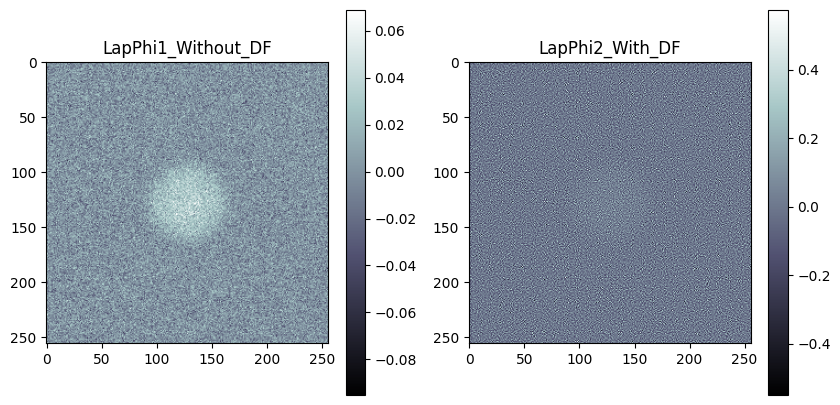

In [10]:
ref = Ir[1, :, :]
sam = Is[1, :, :]

lapphi1 = (ref - sam ) * (
        (2 * np.pi) / (wavelength * prop * ref))#prop * np.divide(ndimage.laplace(DF_filtered * ref), pixel_size ** 2)
lapphi2 =(ref - sam +prop * np.divide(ndimage.laplace(DF_filtered * ref), pixel_size ** 2) ) * (
        (2 * np.pi) / (wavelength * prop * ref))#prop * np.divide(ndimage.laplace(DF_filtered * ref), pixel_size ** 2) 
lapphi = (ref - sam + prop * np.divide(ndimage.laplace(DF_filtered * ref), pixel_size ** 2)) * (
        (2 * np.pi) / (wavelength * prop * ref))      

lapphim = np.concatenate((lapphi1, np.flipud(lapphi1)), axis=0)
kx, ky = kspace_alloo(lapphim.shape, pixel_size)
kxky = np.add.outer(ky ** 2, kx ** 2)

ft_lapphi = np.fft.fftshift(np.fft.fft2(lapphim))
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(lapphi1, cmap='bone')
plt.title('LapPhi1_Without_DF')
plt.colorbar()
plt.subplot(122)
plt.imshow(lapphi2, cmap='bone')
plt.title('LapPhi2_With_DF')
plt.colorbar()
#np.savetxt(f'MIST_ALUMINA_RESULTS/Lapphi1_{energy}kev.txt', lapphi1)
#np.savetxt(f'MIST_ALUMINA_RESULTS/Lapphi2_{energy}kev.txt', lapphi2)

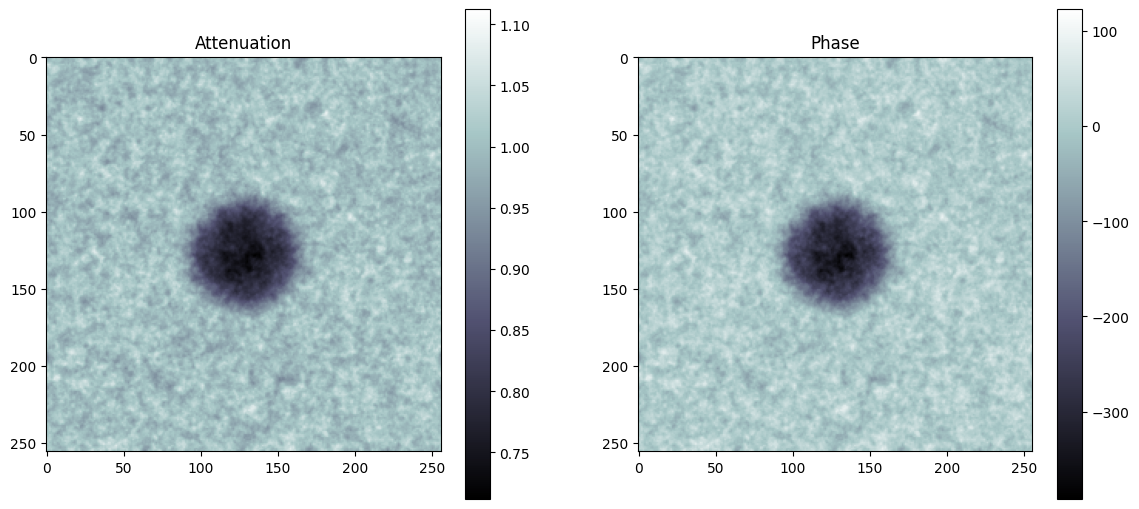

In [11]:
e = 0.0001  #e = 0.0001 This regularises the inverse Fourier transform around the origin of Fourier space (may need tweaking)
# this parameter could be change depend on requirements and pixel's size.
insideift = ft_lapphi / (kxky + e)
phi = np.fft.ifft2(np.fft.ifftshift(insideift))
phi = -1 * np.real(phi) # This is the phase-shifts imparted on the X-ray wave-field by the object
phi = phi[0:int(rows), :]
Iob = np.exp(2 * phi / (gamma)) # This is the object's attenuation term
DF_atten = np.real(DF_filtered / Iob)
np.savetxt(f'FS_Measurements_txt_Files/Phase_21_kev_300umFS.txt', phi)
plt.figure(figsize=(14, 14))


plt.subplot(2,2,1)
plt.imshow(Iob, cmap='bone')
plt.colorbar()
plt.title('Attenuation')
plt.subplot(2,2,2)
plt.imshow(phi, cmap='bone')
plt.title('Phase')
plt.colorbar()


Text(0.5, 1.0, 'DF Attenuation')

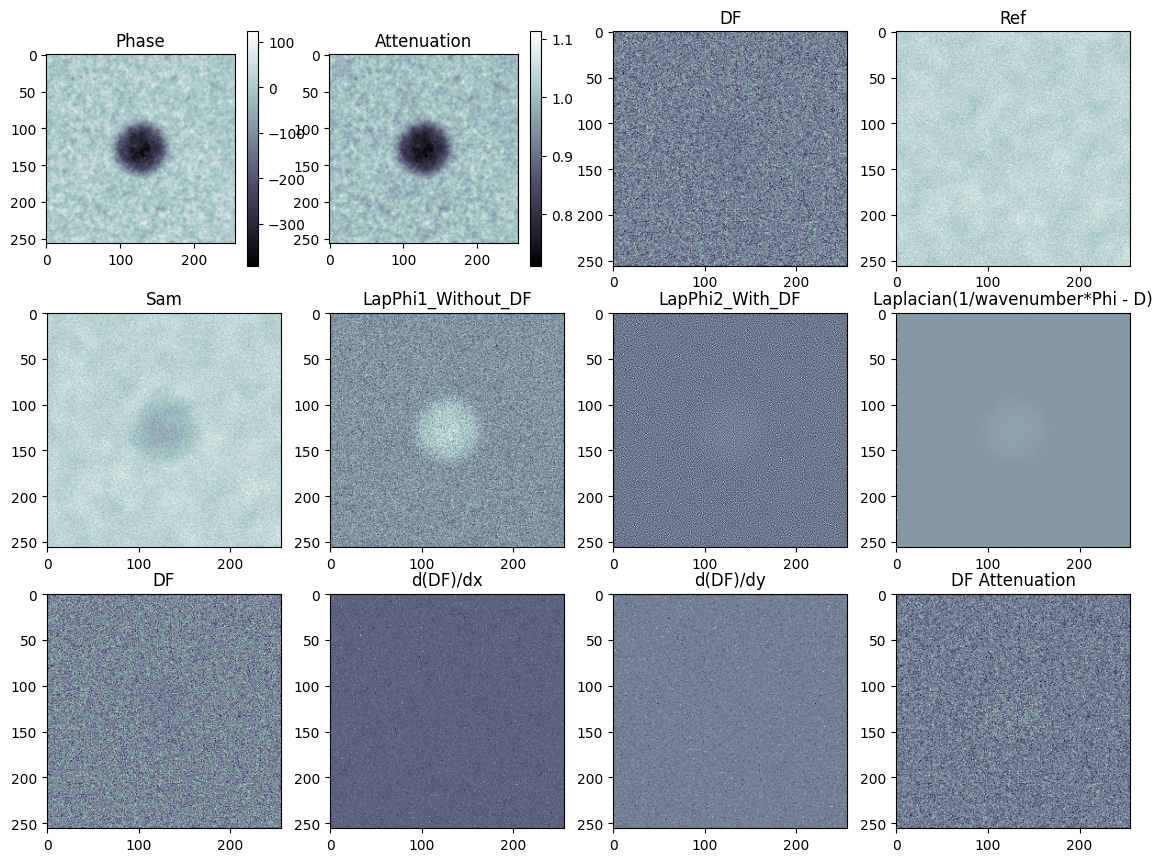

In [12]:
plt.figure(figsize=(14, 14))
plt.subplot(4,4,1)
plt.imshow(phi, cmap='bone')
plt.title('Phase')
plt.colorbar()

plt.subplot(4,4,2)
plt.imshow(Iob, cmap='bone')
plt.colorbar()
plt.title('Attenuation')
plt.subplot(4,4,3)
plt.imshow(DF_filtered, cmap='bone')
plt.title('DF')
plt.subplot(4,4,4)
plt.imshow(ref, cmap='bone')
plt.title('Ref')
plt.subplot(4,4,5)
plt.imshow(sam, cmap='bone')
plt.title('Sam')
plt.subplot(4,4,6)
plt.imshow(lapphi1, cmap='bone')
plt.title('LapPhi1_Without_DF')
plt.subplot(4,4,7)
plt.imshow(lapphi2, cmap='bone')
plt.title('LapPhi2_With_DF')
plt.subplot(4,4,8)
plt.imshow(lap_phiDF, cmap='bone')
plt.title('Laplacian(1/wavenumber*Phi - D)')
plt.subplot(4,4,9)
plt.imshow(DFqr, cmap='bone')
plt.title('DF')
plt.subplot(4,4,10)
plt.imshow(dxDF, cmap='bone')
plt.title('d(DF)/dx')
plt.subplot(4,4,11)
plt.imshow(dyDF, cmap='bone')
plt.title('d(DF)/dy')
plt.subplot(4,4,12)
plt.imshow(DF_atten, cmap='bone')
plt.title('DF Attenuation')


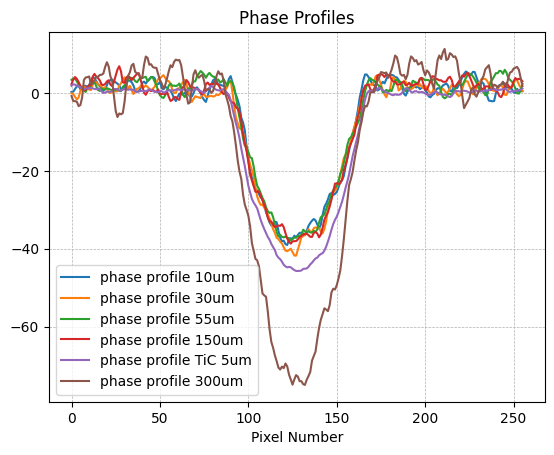

In [15]:
phase_10um = np.genfromtxt('FS_Measurements_txt_Files/Phase_21_kev_10umFS.txt')
phase_15um = np.genfromtxt('FS_Measurements_txt_Files/Phase_21_kev_15umFS.txt')
phase_20um = np.genfromtxt('FS_Measurements_txt_Files/Phase_21_kev_20umFS.txt')
phase_25um = np.genfromtxt('FS_Measurements_txt_Files/Phase_21_kev_25umFS.txt')
phase_30um = np.genfromtxt('FS_Measurements_txt_Files/Phase_21_kev_30umFS.txt')
phase_40um = np.genfromtxt('FS_Measurements_txt_Files/Phase_21_kev_40umFS.txt')
phase_45um = np.genfromtxt('FS_Measurements_txt_Files/Phase_21_kev_45umFS.txt')
phase_50um = np.genfromtxt('FS_Measurements_txt_Files/Phase_21_kev_50umFS.txt')
phase_55um = np.genfromtxt('FS_Measurements_txt_Files/Phase_21_kev_55mFS.txt')
phase_150um = np.genfromtxt('FS_Measurements_txt_Files/Phase_21_kev_150umFS.txt')
phase_TiC = np.genfromtxt('FS_Measurements_txt_Files/Phase_19_kev_5umFS_TiC_70_35.txt')
phase_TiC = np.genfromtxt('FS_Measurements_txt_Files/Phase_19_kev_5umFS_TiC_70_35.txt')*np.min(phase_10um)/np.min(np.min(phase_TiC))
phase_300um = np.genfromtxt('FS_Measurements_txt_Files/Phase_21_kev_300umFS.txt')


plt.plot(np.mean(phase_10um,axis=0), label='phase profile 10um')
#plt.plot(np.mean(phase_15um,axis=0), label='phase profile 15um')
#plt.plot(np.mean(phase_20um,axis=0), label='phase profile 20um')
#plt.plot(np.mean(phase_25um,axis=0), label='phase profile 25um')
plt.plot(np.mean(phase_30um,axis=0), label='phase profile 30um')
#plt.plot(np.mean(phase_40um,axis=0), label='phase profile 40um')
#plt.plot(np.mean(phase_45um,axis=0), label='phase profile 45um')
#plt.plot(np.mean(phase_50um,axis=0), label='phase profile 50um')
plt.plot(np.mean(phase_55um,axis=0), label='phase profile 55um')
plt.plot(np.mean(phase_150um,axis=0), label='phase profile 150um')
plt.plot(np.mean(phase_TiC,axis=0), label='phase profile TiC 5um')
plt.plot(np.mean(phase_300um,axis=0), label='phase profile 300um')
plt.grid(linestyle='--', linewidth=0.5  )
plt.title('Phase Profiles')
plt.xlabel('Pixel Number')
plt.legend()

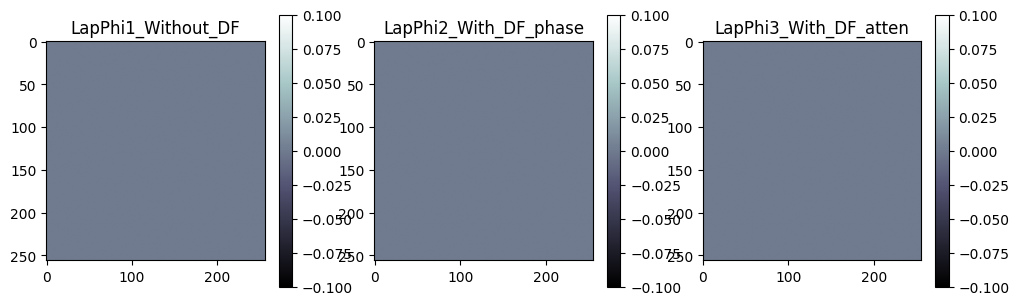

In [138]:
ref = Ir[1, :, :]
sam = Is[1, :, :]

lapphi1 = (ref - sam ) * (
        (2 * np.pi) / (wavelength * prop * ref))#prop * np.divide(ndimage.laplace(DF_filtered * ref), pixel_size ** 2)
lapphi2 =(ref - sam +prop * np.divide(ndimage.laplace(DF_filtered * ref), pixel_size ** 2) ) * (
        (2 * np.pi) / (wavelength * prop * ref))#prop * np.divide(ndimage.laplace(DF_filtered * ref), pixel_size ** 2) 
lapphi3 = (ref - sam + prop * np.divide(ndimage.laplace(DF_atten * ref), pixel_size ** 2)) * (
        (2 * np.pi) / (wavelength * prop * ref))      

lapphim = np.concatenate((lapphi1, np.flipud(lapphi1)), axis=0)
kx, ky = kspace_alloo(lapphim.shape, pixel_size)
kxky = np.add.outer(ky ** 2, kx ** 2)

ft_lapphi = np.fft.fftshift(np.fft.fft2(lapphim))
plt.figure(figsize=(12, 12))
plt.subplot(331)
plt.imshow(lapphi1, cmap='bone')
plt.title('LapPhi1_Without_DF')
plt.colorbar()
plt.subplot(332)
plt.imshow(lapphi2, cmap='bone')
plt.title('LapPhi2_With_DF_phase')
plt.colorbar()
plt.subplot(333)
plt.imshow(lapphi3, cmap='bone')
plt.title('LapPhi3_With_DF_atten')
plt.colorbar()

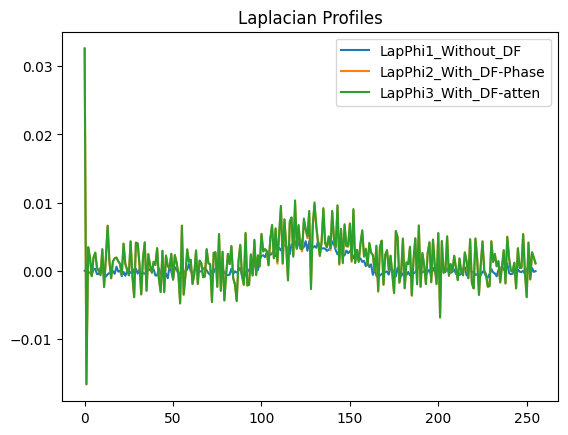

In [100]:

plt.plot(np.mean(lapphi1, axis=0), label='LapPhi1_Without_DF')
plt.plot(np.mean(lapphi2, axis=0), label='LapPhi2_With_DF-Phase')
plt.plot(np.mean(lapphi3, axis=0), label='LapPhi3_With_DF-atten')
plt.title('Laplacian Profiles')
plt.legend()

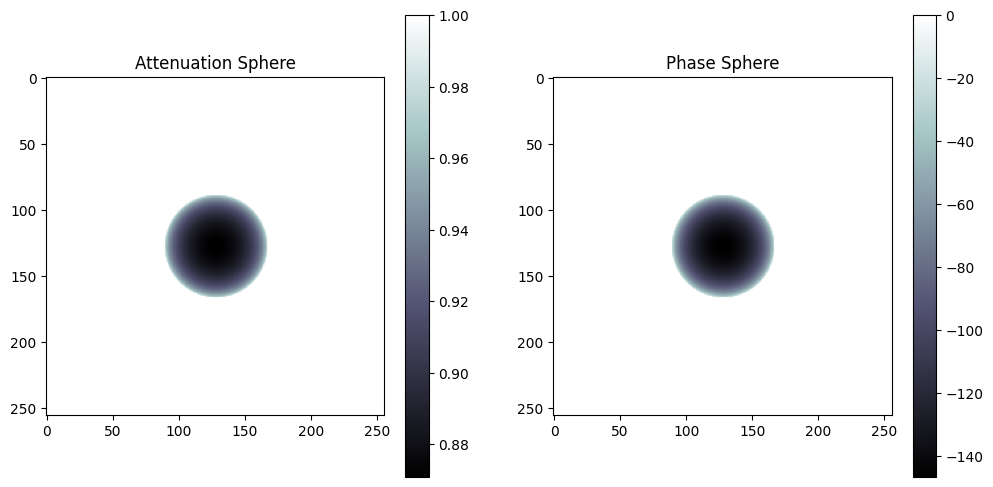

64.50893600132852


In [31]:
import cv2
E=19*(10**(3))
E_J=E*1.6*(10**(-19))
h=6.63*10**(-34)
c=3*(10**(8))
k1=(2*np.pi*E_J)/(h*c)
beta_PMMA = 3.3587E-10
delta_PMMA =7.1249E-07
mu_PMMA = 2*k1* beta_PMMA 
sh = (256, 256)
ssize = 2.    # rough speckle size
sphere_radius = 39
lam = .5e-10  # wavelength

z = 5e-2      # propagation distance
psize = 55e-6  # pixel size
xx, yy = np.indices(sh)
sphere = np.real(np.sqrt(np.maximum(0, sphere_radius**2 - (xx-128.)**2 - (yy-128.)**2)))*psize
DxSphere = cv2.Sobel(sphere, cv2.CV_64F, 1, 0, ksize=9)
BL_Sphere = np.exp(-mu_PMMA*(sphere))
Phase_Sphere = -delta_PMMA*k1*(sphere)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(BL_Sphere, cmap='bone')
plt.colorbar()
plt.title('Attenuation Sphere')
plt.subplot(122)
plt.imshow(Phase_Sphere, cmap='bone')
plt.colorbar()
plt.title('Phase Sphere')
plt.show()
print(mu_PMMA)


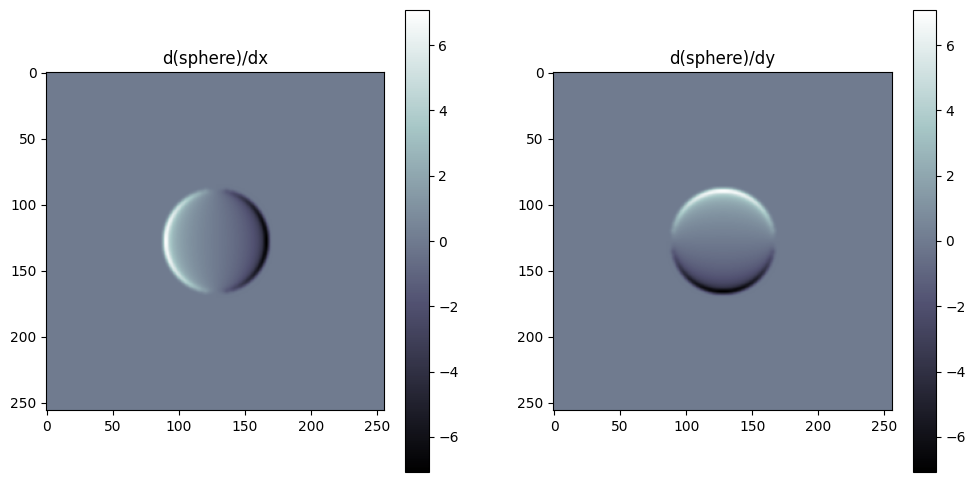

In [32]:
dx_sphere = cv2.Sobel(sphere, cv2.CV_64F, 1, 0, ksize=9)
dy_sphere = cv2.Sobel(sphere, cv2.CV_64F, 0, 1, ksize=9)
plt.figure(figsize=(12, 6)) 
plt.subplot(121)
plt.imshow(dx_sphere, cmap='bone')
plt.title('d(sphere)/dx')
plt.colorbar()
plt.subplot(122)
plt.imshow(dy_sphere, cmap='bone')
plt.title('d(sphere)/dy')
plt.colorbar()
plt.show()

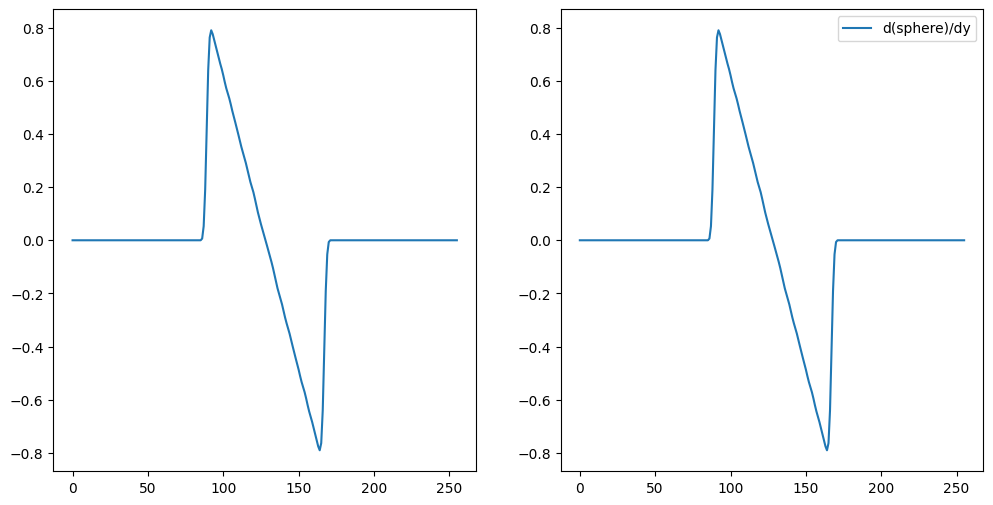

In [33]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(np.mean(dx_sphere, axis=0), label='d(sphere)/dx')
plt.subplot(122)
plt.plot(np.mean(dy_sphere, axis=1), label='d(sphere)/dy')
plt.legend()

NameError: name 'lapphi3' is not defined

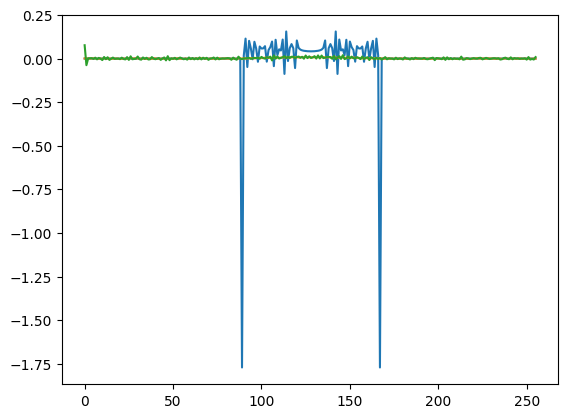

In [34]:
Laplace_BL_Sphere = cv2.Laplacian(Phase_Sphere, cv2.CV_64F)
plt.plot(np.mean(Laplace_BL_Sphere, axis=0), label='Laplace_BL_Sphere')
plt.plot(np.mean(lapphi1, axis=0), label='LapPhi1_Without_DF')
plt.plot(np.mean(lapphi2, axis=0), label='LapPhi2_With_DF-Phase')
plt.plot(np.mean(lapphi3, axis=0), label='LapPhi3_With_DF-atten')
plt.title('Laplacian Profile Phase_Sphere Theroetical')
plt.legend()
plt.grid(linestyle='--')

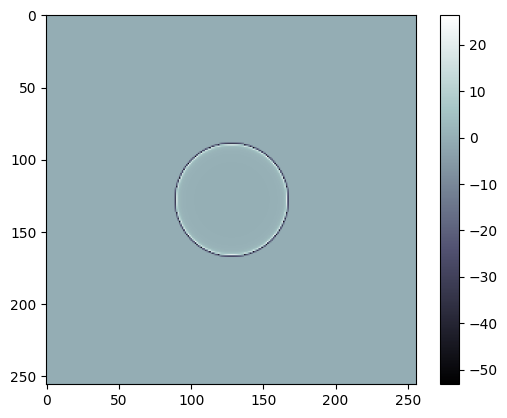

In [35]:
plt.imshow(Laplace_BL_Sphere, cmap='bone')
plt.colorbar()

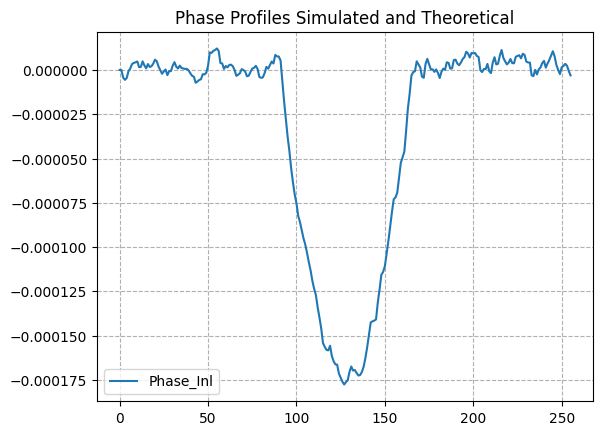

In [51]:
phase_Inl = np.genfromtxt('MIST_ALUMINA_RESULTS/phase_inline_15.txt')
Phase_SIM = np.mean(phase_TiC, axis=0)
Phase_Inl = np.mean(phase_Inl, axis=0)#*np.min(phi)/np.min(np.min(Phase_Sphere)) # This is the experimental phase profile
#Phase_Theo = np.mean(Phase_Sphere, axis=0)*np.min(Phase_Sphere)/np.min((Phase_SIM)) 
phase_SiC = np.mean(phase_10um, axis=0)*np.min(phase_SiC)/np.min(np.min(Phase_SIM)) # Normalising the theoretical phase to the experimental phase
#plt.plot(Phase_SIM, label='Phase_TiC')
plt.plot(Phase_Inl, label='Phase_Inl')
#plt.plot(phase_SiC, label='Phase_SiC')
plt.legend()
plt.title('Phase Profiles Simulated and Theoretical')
plt.grid(linestyle='--')    

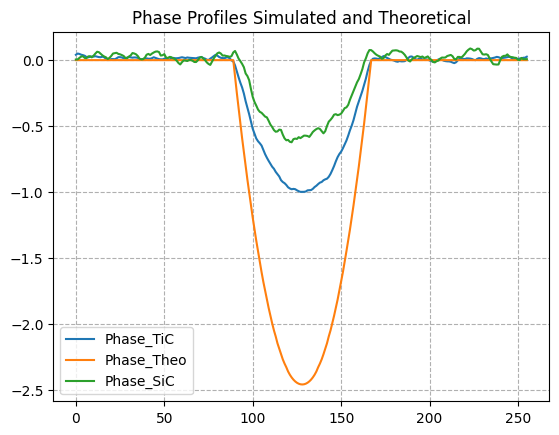

In [49]:


# Asumiendo que ya tienes calculados:
# Phase_SIM, phase_Inl, Phase_Sphere, phase_10um, phase_SiC

# 1. Normalizar Phase_SIM (si no está ya normalizado)
Phase_SIM_normalized = Phase_SIM / np.max(np.abs(Phase_SIM))  # o usar np.min, dependiendo de tu necesidad

# 2. Normalizar los otros perfiles respecto a Phase_SIM
Phase_Inl_normalized = np.mean(phase_Inl, axis=0) * (np.min(phi)/np.min(np.min(Phase_Sphere))) / np.max(np.abs(Phase_SIM))
Phase_Theo_normalized = np.mean(Phase_Sphere, axis=0) * (np.min(Phase_Sphere)/np.min(Phase_SIM)) / np.max(np.abs(Phase_SIM))
phase_SiC_normalized = np.mean(phase_10um, axis=0) * (np.min(phase_SiC)/np.min(np.min(Phase_SIM))) / np.max(np.abs(Phase_SIM))
plt.plot(Phase_SIM_normalized, label='Phase_TiC')
plt.plot(Phase_Theo_normalized, label='Phase_Theo')
plt.plot(phase_SiC_normalized, label='Phase_SiC')
plt.legend()
plt.title('Phase Profiles Simulated and Theoretical')
plt.grid(linestyle='--') 

In [107]:
phi_26_75 = np.loadtxt('MIST_ALUMINA_RESULTS/Phase_26.75kev.txt')
phi_24_25 = np.loadtxt('MIST_ALUMINA_RESULTS/Phase_24.25kev.txt')
phi_21_75 = np.loadtxt('MIST_ALUMINA_RESULTS/Phase_21.75kev.txt')   
phi_19_25 = np.loadtxt('MIST_ALUMINA_RESULTS/Phase_19.25kev.txt')
phi_16_75 = np.loadtxt('MIST_ALUMINA_RESULTS/Phase_16.75kev.txt')
phi_14_25 = np.loadtxt('MIST_ALUMINA_RESULTS/Phase_14.25kev.txt')
phi_11_75 = np.loadtxt('MIST_ALUMINA_RESULTS/Phase_11.75kev.txt')

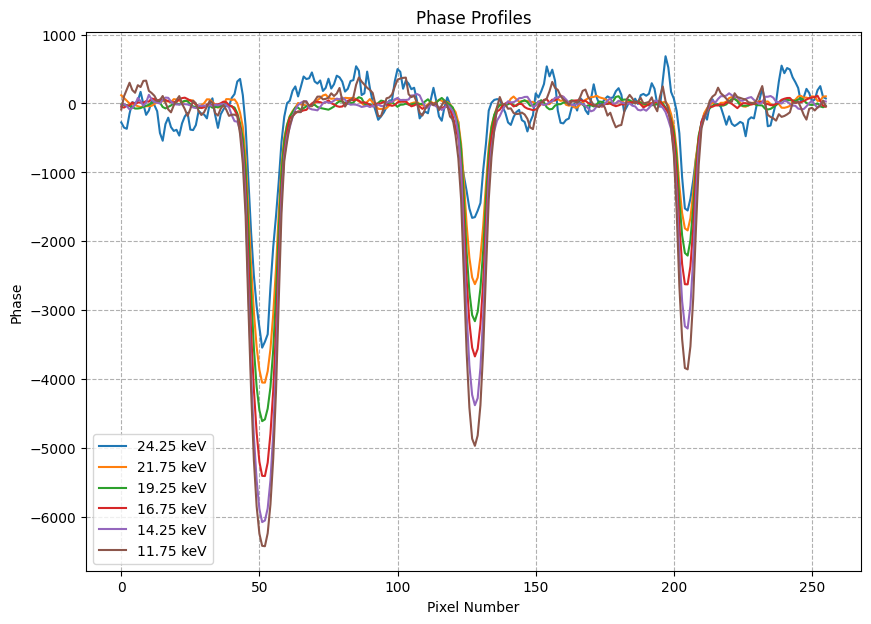

In [108]:
#Calcular perfiles normalizados en el mismo plot para las phases
plt.figure(figsize=(10, 7))
#plt.plot(phi_26_75[128, :], label='26.75 keV')
plt.plot(phi_24_25[128, :], label='24.25 keV')
plt.plot(phi_21_75[128, :], label='21.75 keV')
plt.plot(phi_19_25[128, :], label='19.25 keV')
plt.plot(phi_16_75[128, :], label='16.75 keV')
plt.plot(phi_14_25[128, :], label='14.25 keV')
plt.plot(phi_11_75[128, :], label='11.75 keV')
plt.title('Phase Profiles')
plt.xlabel('Pixel Number')
plt.ylabel('Phase')
plt.legend()
plt.grid(linestyle='--')


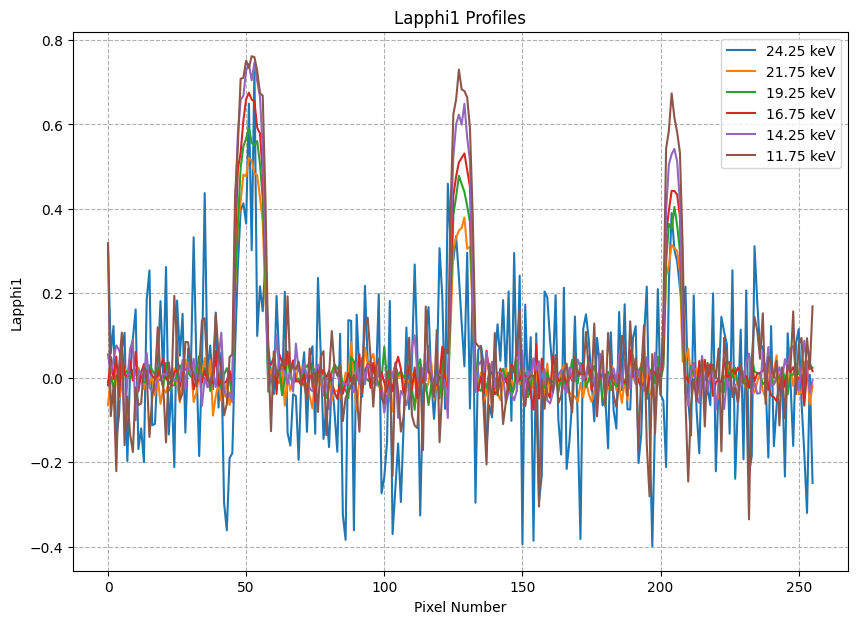

In [109]:
#cargamos los archivos nombrados lapphi1
lapphi1_26_75 = np.loadtxt('MIST_ALUMINA_RESULTS/Lapphi1_26.75kev.txt')
lapphi1_24_25 = np.loadtxt('MIST_ALUMINA_RESULTS/Lapphi1_24.25kev.txt')
lapphi1_21_75 = np.loadtxt('MIST_ALUMINA_RESULTS/Lapphi1_21.75kev.txt')
lapphi1_19_25 = np.loadtxt('MIST_ALUMINA_RESULTS/Lapphi1_19.25kev.txt')
lapphi1_16_75 = np.loadtxt('MIST_ALUMINA_RESULTS/Lapphi1_16.75kev.txt')
lapphi1_14_25 = np.loadtxt('MIST_ALUMINA_RESULTS/Lapphi1_14.25kev.txt')
lapphi1_11_75 = np.loadtxt('MIST_ALUMINA_RESULTS/Lapphi1_11.75kev.txt')
#Calcular perfiles normalizados en el mismo plot para las lapphi1
plt.figure(figsize=(10, 7))
#plt.plot(lapphi1_26_75[128, :], label='26.75 keV')
plt.plot(lapphi1_24_25[128, :], label='24.25 keV')
plt.plot(lapphi1_21_75[128, :], label='21.75 keV')
plt.plot(lapphi1_19_25[128, :], label='19.25 keV')
plt.plot(lapphi1_16_75[128, :], label='16.75 keV')
plt.plot(lapphi1_14_25[128, :], label='14.25 keV')
plt.plot(lapphi1_11_75[128, :], label='11.75 keV')
plt.title('Lapphi1 Profiles')
plt.xlabel('Pixel Number')
plt.ylabel('Lapphi1')
plt.legend()
plt.grid(linestyle='--')


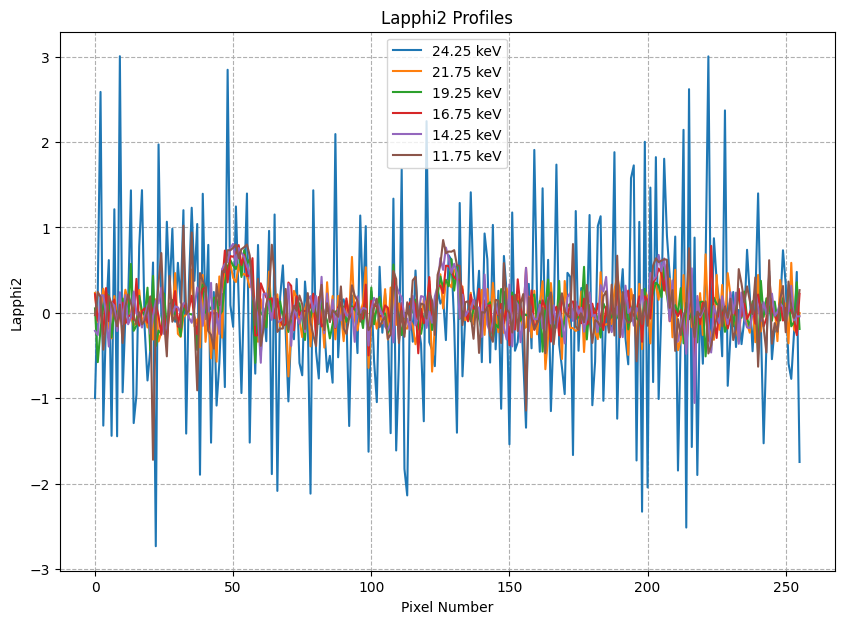

In [110]:
#AHORA CON EL ARCHIVO lapphi2
lapphi2_26_75 = np.loadtxt('MIST_ALUMINA_RESULTS/Lapphi2_26.75kev.txt')
lapphi2_24_25 = np.loadtxt('MIST_ALUMINA_RESULTS/Lapphi2_24.25kev.txt')
lapphi2_21_75 = np.loadtxt('MIST_ALUMINA_RESULTS/Lapphi2_21.75kev.txt')
lapphi2_19_25 = np.loadtxt('MIST_ALUMINA_RESULTS/Lapphi2_19.25kev.txt')
lapphi2_16_75 = np.loadtxt('MIST_ALUMINA_RESULTS/Lapphi2_16.75kev.txt')
lapphi2_14_25 = np.loadtxt('MIST_ALUMINA_RESULTS/Lapphi2_14.25kev.txt')
lapphi2_11_75 = np.loadtxt('MIST_ALUMINA_RESULTS/Lapphi2_11.75kev.txt')
#Calcular perfiles normalizados en el mismo plot para las lapphi2
plt.figure(figsize=(10, 7))
#plt.plot(lapphi2_26_75[128, :], label='26.75 keV')
plt.plot(lapphi2_24_25[128, :], label='24.25 keV')
plt.plot(lapphi2_21_75[128, :], label='21.75 keV')
plt.plot(lapphi2_19_25[128, :], label='19.25 keV')
plt.plot(lapphi2_16_75[128, :], label='16.75 keV')
plt.plot(lapphi2_14_25[128, :], label='14.25 keV')
plt.plot(lapphi2_11_75[128, :], label='11.75 keV')
plt.title('Lapphi2 Profiles')
plt.xlabel('Pixel Number')
plt.ylabel('Lapphi2')
plt.legend()
plt.grid(linestyle='--')
plt.show()


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters, measure, morphology

# Supón que tienes el array de la imagen (normalizado o en escala de grises)
img_array = phase_300um

# 1. Umbral automático para detectar regiones oscuras
threshold = filters.threshold_otsu(img_array)
mask = img_array < threshold  # Regiones más oscuras que el fondo

# 2. Limpiar pequeñas regiones (ruido)
mask_clean = morphology.remove_small_objects(mask, min_size=10)

# 3. Etiquetar las regiones oscuras detectadas
labeled = measure.label(mask_clean)
regions = measure.regionprops(labeled, intensity_image=img_array)

# 4. Calcular intensidad promedio de las regiones oscuras
osc_intensities = [r.mean_intensity for r in regions]
mu_osc = np.mean(osc_intensities)

# 5. Calcular fondo (zonas fuera de los oscuros)
background = np.logical_not(mask_clean)
fondo_vals = img_array[background]
mu_fondo = np.mean(fondo_vals)
std_fondo = np.std(fondo_vals)

# 6. Calcular CNR
cnr = (mu_osc - mu_fondo) / std_fondo

print(f"CNR = {cnr:.3f}")



CNR = -9.642


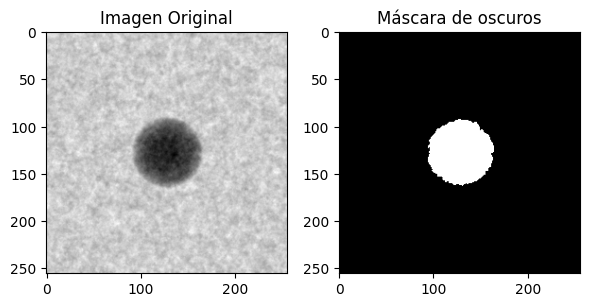

In [39]:
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.imshow(img_array, cmap='gray')
plt.title('Imagen Original')

plt.subplot(1, 2, 2)
plt.imshow(mask_clean, cmap='gray')
plt.title('Máscara de oscuros')
plt.tight_layout()
plt.show()


In [ ]:
cnr_cut=np.array([10.58, 10.58, 10.58, 10.58, cnr, cnr, cnr])
Cut = np.array([0.01,0.1,1,10,100,1000,10000])
energy = np.array([11.75, 14.25, 16.75, 19.25, 21.75, 24.25, 26.75])
cnr = np.array([21.7, 34.17, 37.13, 39.76, 31.64, 20, 1.6])

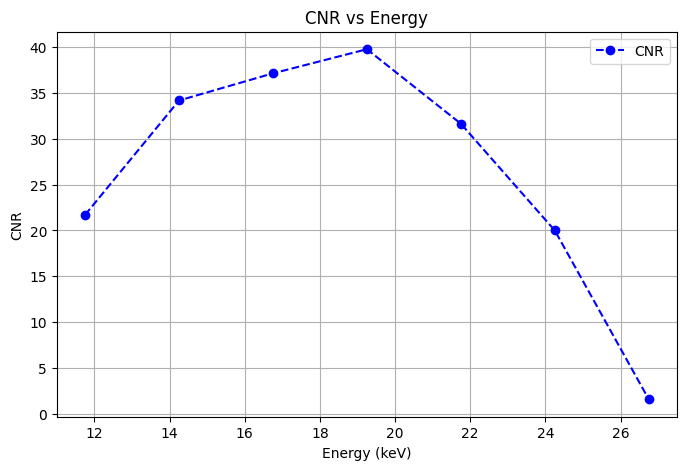

In [20]:
#grafica de CNR vs energpia con linea de tendencia punteada
plt.figure(figsize=(8, 5))
plt.plot(energy, cnr, marker='o', linestyle='--', color='b', label='CNR')
plt.title('CNR vs Energy')
plt.xlabel('Energy (keV)')
plt.ylabel('CNR')
plt.grid()
plt.legend()
plt.show()


In [21]:
CNR_phase = np.array([10.58,10.64,10.57,10.56,10.64,10.48,10.58,10.56,10.57])
FS_Size = np.array([10, 15, 20, 25, 30, 40, 45, 50, 55])

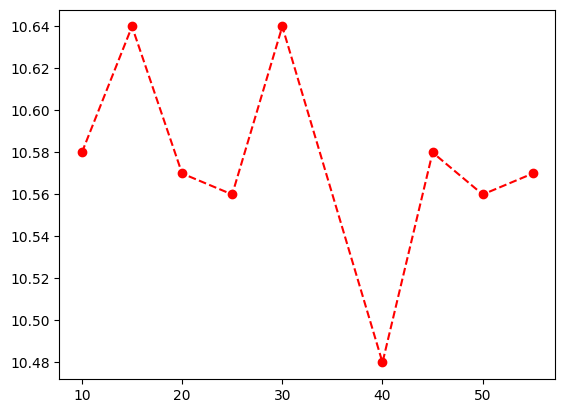

In [22]:
plt.plot(FS_Size, CNR_phase, marker='o', linestyle='--', color='r', label='CNR Phase')

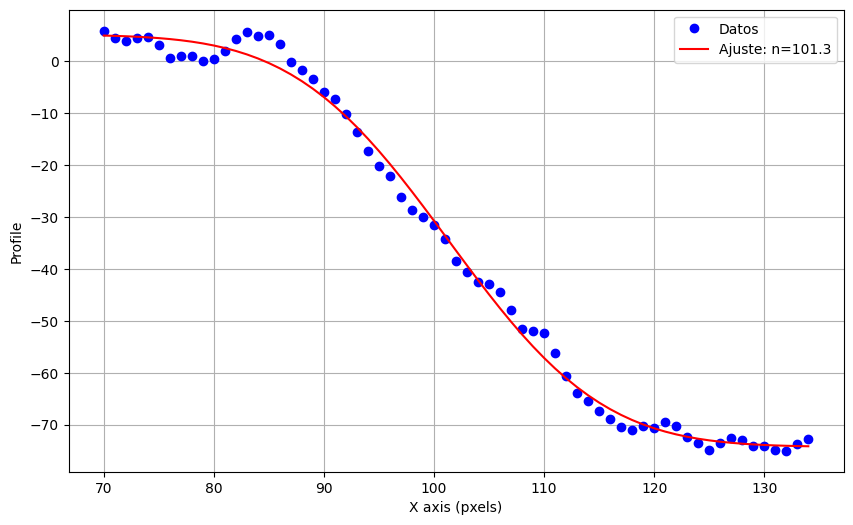

Parámetros del ajuste:
A = -39.6983 ± 0.5654
n = 101.3391 ± 0.2821 (centro del ajuste)
m = -34.5754 ± 0.4449
b = 11.0119 ± 0.3987


In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import erf
def PI(name,inicial,final,h,y):
    P=np.zeros(y-h)
    for i in range(inicial,final):
        P=P+name[i,h:y]
    mean=P/(final-inicial)
    return mean

# Datos
ColI = 70
ColF = 135
x = np.arange(ColI, ColF, 1)
y_data = PI(phase_300um, 0, 256, ColI, ColF)  # Asegúrate de que y_data tenga la misma longitud que x

# Modelo
def func(x, A, n, m, b):
    return A * erf((x - n) / (np.sqrt(2) * b)) + m
def derfunc(x, A, n, b):
    k=A*np.sqrt(2/np.pi)*np.exp(-(x-n)**2/(2*b**2))/b
    return k

# Guess inicial inteligente
n_guess = x[np.argmax(y_data)]  # Centro en el pico de los datos
guess = [np.max(y_data) - np.min(y_data), n_guess, np.min(y_data), 10]  # A, n, m, b

# Ajuste
res_p, cov_p = curve_fit(func, x, y_data, guess)
y_fit = func(x, *res_p)

# Gráfico
plt.figure(figsize=(10, 6))
plt.plot(x, y_data, 'bo', label='Datos')
plt.plot(x, y_fit, 'r-', label=f'Ajuste: n={res_p[1]:.1f}')
plt.xlabel('X axis (pxels)')
plt.ylabel('Profile')
plt.legend()
plt.grid(True)
plt.show()

# Resultados
print("Parámetros del ajuste:")
print(f"A = {res_p[0]:.4f} ± {np.sqrt(cov_p[0, 0]):.4f}")
print(f"n = {res_p[1]:.4f} ± {np.sqrt(cov_p[1, 1]):.4f} (centro del ajuste)")
print(f"m = {res_p[2]:.4f} ± {np.sqrt(cov_p[2, 2]):.4f}")
print(f"b = {res_p[3]:.4f} ± {np.sqrt(cov_p[3, 3]):.4f}")

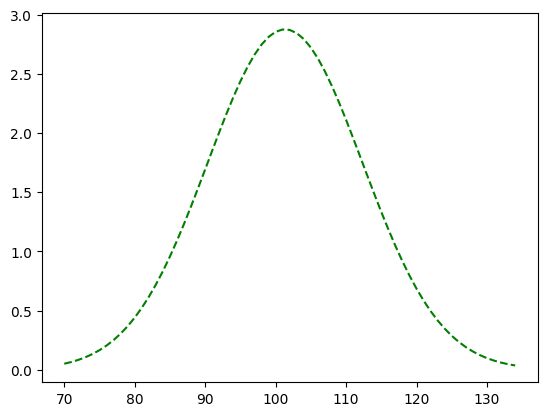

In [24]:
plt.plot(x, -derfunc(x, res_p[0], res_p[1], res_p[3]), 'g--', label='Derivada del ajuste')

In [25]:
FWHM = 2 * res_p[3] * np.sqrt(2 * np.log(2))  # Full Width at Half Maximum
print(f"FWHM = {FWHM:.4f} píxeles")

FWHM = 25.9311 píxeles


In [26]:
FS_Size = np.array([10, 15, 20, 25, 30, 40, 45, 50, 55,150,300])
FWHM = np.array([15.31,21, 22.11,22.6,19.86,18.09,18.5, 17.94, 19.15,18.3,25.93])#21.25

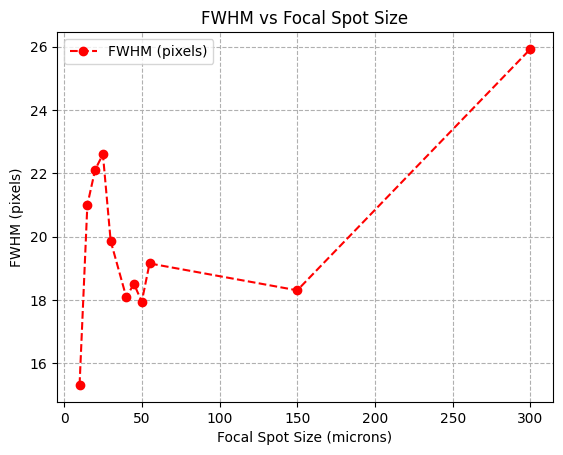

In [27]:
plt.plot(FS_Size,FWHM, marker='o', linestyle='--', color='r', label='FWHM (pixels)')
plt.title('FWHM vs Focal Spot Size')
plt.xlabel('Focal Spot Size (microns)')
plt.ylabel('FWHM (pixels)')
plt.grid(linestyle='--')
plt.legend()

Text(0.5, 1.0, 'Phase Profile Region')

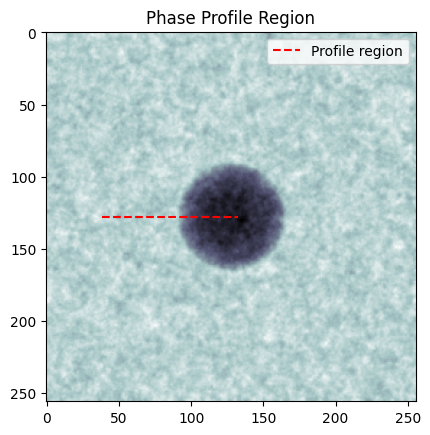

In [35]:
plt.imshow(phase_55um, cmap='bone')
plt.axhline(y=128,xmin =0.15,xmax=0.52, color='red', linestyle='--', label='Profile region')
plt.legend()
plt.title('Phase Profile Region')